# Result analysis

## Setting up the kernel

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
import seaborn as sns


from rich import print
from tqdm import tqdm
from pathlib import Path
from ewatercycle_DA import DA
from datetime import datetime
from scipy.stats import qmc
from ipywidgets import IntProgress

## Loading in observed data

In [2]:
# Loading in discharge data from Katima Mulilo
katima = (pd.read_csv('Katima_Mulilo/1291100_Q_Day.txt', skiprows=35, delimiter=';', header=1)
          .drop(columns=['hh:mm'])
          .rename(columns={"YYYY-MM-DD": "Date", " Value": "Discharge [m^3/s]"}))

# Creating a dataframe with accessible dates and no invalid data 
katima['Date'] = pd.to_datetime(katima['Date'])
katima['Discharge [m^3/s]'] = katima['Discharge [m^3/s]'].replace(-999.000, np.nan)

# Defining the data period
start_calibration = '1986-01-01'
end_calibration = '2012-12-31'

# Reducing the dataframe to the calibration period
km = katima[(katima['Date'] >= start_calibration) & (katima['Date'] <= end_calibration)]

# Creating a dataframe of the flow data 
flow = pd.DataFrame(data=km['Discharge [m^3/s]'].values, index=km['Date'], columns=['Q'])

In [10]:
# The HBV model returns values in mm/day so in order to compare this to the observed data it must b converted to m^3/s
catchment_area_km2 = 334882.8

def mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

## Defining the experiment dates and file paths

In [3]:
# Defining the data period
start_historic = '1986-11-01'
end_historic = '2017-10-31'

future_data_start = '2026-11-01'
future_data_end = '2099-10-31' 

start_hydro_year = 1987
end_hydro_year = 2014

start_future_hydro_year = 2027
end_future_hydro_year = 2099

In [6]:
# defining path for catchment shape file
km_shp = Path.home() / "BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG" /  "km_ERA5" / "km.shp"

# defining destination path for CMIP data
CMIP_folder = Path.home() / "CMIP"
CMIP_folder.mkdir(exist_ok=True)

# model HBV destination path
HBV_model_path = Path.home() / "HBV_model" / "CMIP"
HBV_model_path.mkdir(exist_ok=True)

# Loading in CMIP6 forcings
CMIP_historic = CMIP_folder / "scen_historic" / "work" / "diagnostic" / "script" 
historic = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_historic)

CMIP_119 = CMIP_folder / "scen_119" / "work" / "diagnostic" / "script" 
SSP119 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_119)

CMIP_126 = CMIP_folder / "scen_126" / "work" / "diagnostic" / "script" 
SSP126 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_126)

CMIP_245 = CMIP_folder / "scen_245" / "work" / "diagnostic" / "script" 
SSP245 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_245)

CMIP_370 = CMIP_folder / "scen_370" / "work" / "diagnostic" / "script" 
SSP370 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_370)

CMIP_585 = CMIP_folder / "scen_585" / "work" / "diagnostic" / "script" 
SSP585 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_585)

## Giving the input parameters

In [7]:
# Applying the parameters found in the KGE model fit calibration
params_KGE = [5.65179127, 0.27593564, 779.15056566, 2.45298864, 0.04682875, 1.3263829, 0.01356608, 0.0070803, 0.48990002]

# Define the initial state parameters (Si,  Su, Sf, Ss, Sp)
s_0 = np.array([0,  100,  0,  5,  0])

## Running the HBV model for each scenario

In [8]:
forcing_list = [historic, SSP119, SSP126, SSP245, SSP370, SSP585]
output = []
years = []

for forcings in forcing_list:
    model = ewatercycle.models.HBV(forcing=forcings)
    config_file, _ = model.setup(
        parameters=params_KGE, 
        initial_storage=s_0,
        cfg_dir = HBV_model_path)

    model.initialize(config_file)

    Q_m = []
    time = []
    
    while model.time < model.end_time:
        model.update()
        Q_m.append(model.get_value("Q")[0])
        time.append(pd.Timestamp(model.time_as_datetime))
        
    output.append(Q_m)
    years.append(time)
    
    del Q_m, time
    model.finalize()

In [11]:
# Load output data
historic_output = pd.Series(data=output[0], name="Historic", index=years[0])[start_historic:]
SSP119_output = pd.Series(data=output[1], name="SSP126", index=years[1])[future_data_start:]
SSP126_output = pd.Series(data=output[2], name="SSP126", index=years[2])[future_data_start:]
SSP245_output = pd.Series(data=output[3], name="SSP245", index=years[3])[future_data_start:]
SSP370_output = pd.Series(data=output[4], name="SSP126", index=years[4])[future_data_start:]
SSP585_output = pd.Series(data=output[5], name="SSP585", index=years[5])[future_data_start:]


# Convert mm/d to m3/s
factor = catchment_area_km2 / 86.4
historic_output *= factor
SSP119_output *= factor
SSP126_output *= factor
SSP245_output *= factor
SSP370_output *= factor
SSP585_output *= factor

<Axes: title={'center': 'hi'}, xlabel='Date', ylabel='Discharge [m^3/s]'>

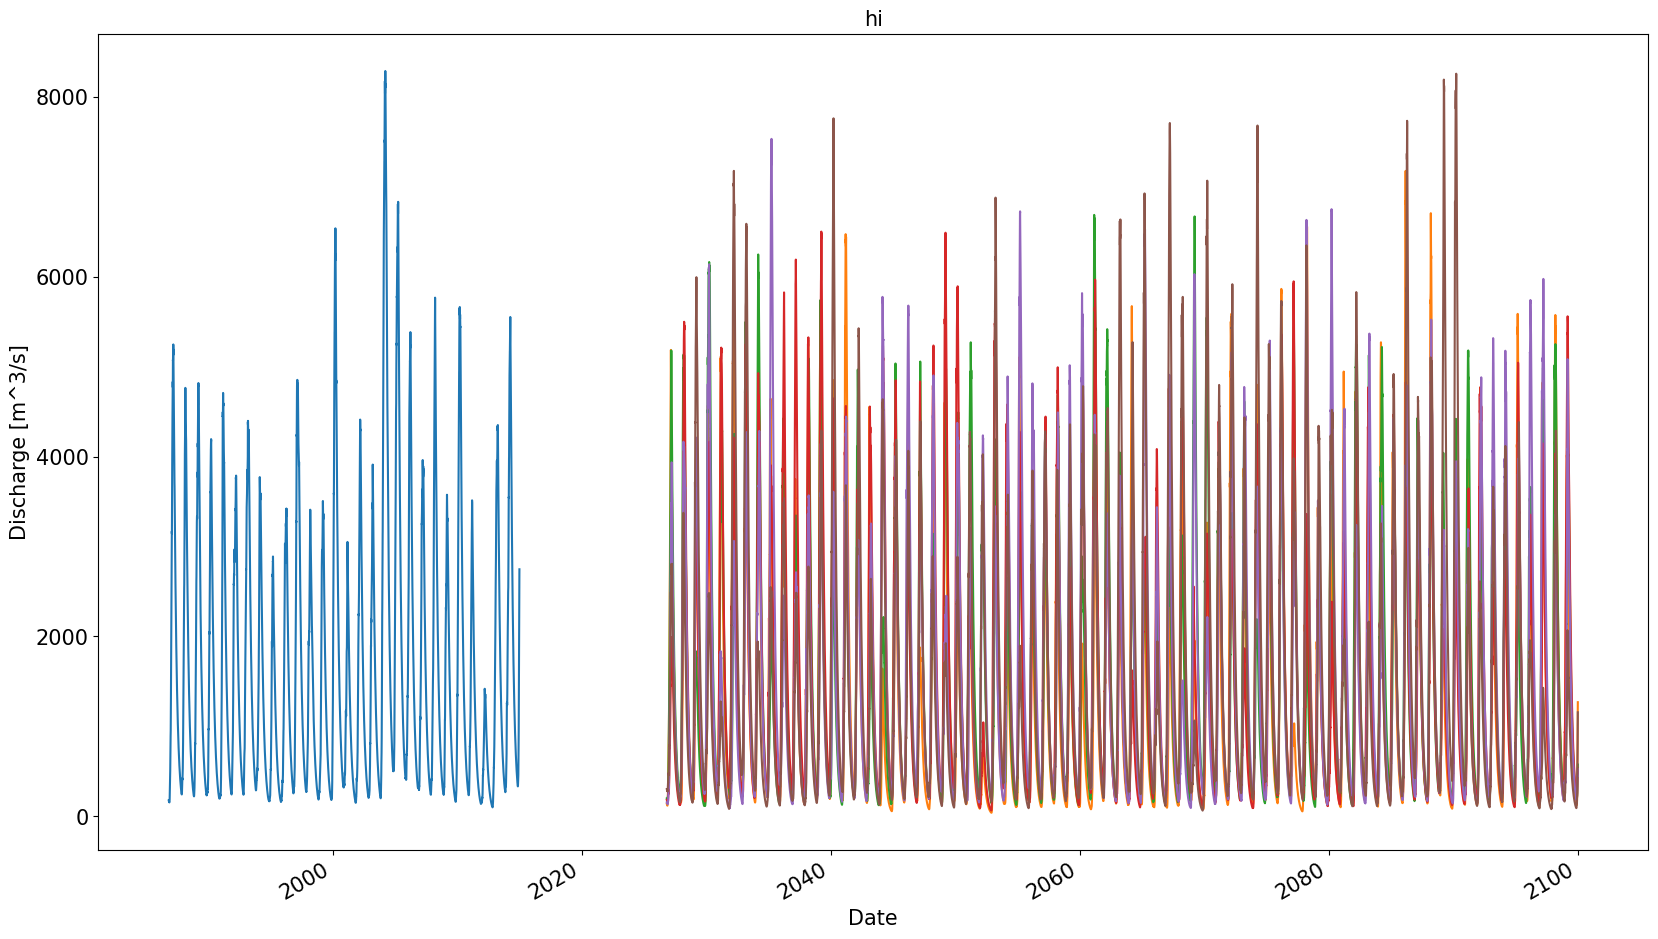

In [28]:
plt.subplots(figsize=(20,12))
plt.title(label='hi', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Discharge [m^3/s]', fontsize=15)

historic_output.plot()
SSP119_output.plot()
SSP126_output.plot()
SSP245_output.plot()
SSP370_output.plot()
SSP585_output.plot()